In [101]:
#change display for the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

## Moving Data Back

In [102]:
import pandas as pd
df = pd.read_csv('full_snax_05-24.csv')

In [103]:
df.dropna(axis = 0, how = 'any', inplace = True)

## Creating New Columns

In [104]:
df['text_length'] = df.text.apply(lambda x: len(x.split()))
df.text_length.head()

0    2341
1    1995
2    1023
3    1377
4    1117
Name: text_length, dtype: int64

In [105]:
df['title_length'] = df.title.apply(lambda x: len(x.split()))
df.title_length.head()

0    1
1    4
2    3
3    2
4    2
Name: title_length, dtype: int64

## Visualizations

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pickle

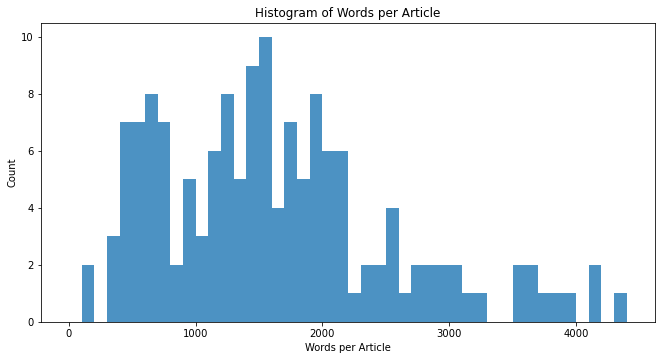

In [107]:
f, ax = plt.subplots(figsize=(11,5.5))

bins = np.linspace(0, 4400, 45)

plt.hist(df.text_length, bins=bins, alpha=0.8)

ax.set(ylabel="Count", xlabel = "Words per Article", title = 'Histogram of Words per Article')

plt.show()

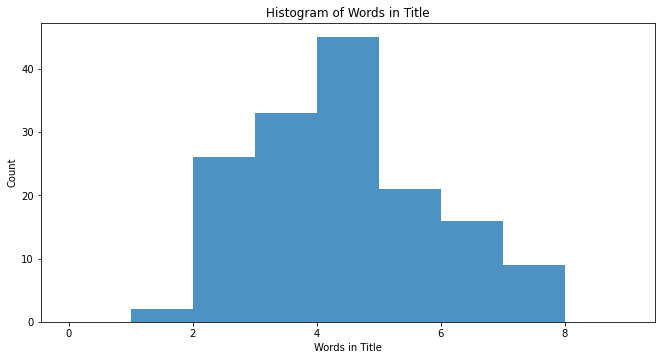

In [108]:
f, ax = plt.subplots(figsize=(11,5.5))

bins = np.linspace(0, 9, 10)

plt.hist(df.title_length, bins=bins, alpha=0.8)

ax.set(ylabel="Count", xlabel = "Words in Title", title = 'Histogram of Words in Title')

plt.show()

In [109]:
#word cloud
from wordcloud import WordCloud, STOPWORDS

In [110]:
#joining a articles together for WordCloud
import string
text = " ".join(art.lower().translate(str.maketrans('', '', string.punctuation)) for art in df.text)

print ("There are {} words in the combination of all articles.".format(len(text)))

There are 1554069 words in the combination of all articles.


In [111]:
#setting stopwords, can update
stopwords = set(STOPWORDS)
#change if wish to update stopwords
stopwords.update(['even', 'snax', 'able', 'snaxshot', r"it's", r"i'm", r"you're", r"don't", r"we've", '2019', '2020', '2021', '2022', 'andrea', 'led', 'may',\
                  'let', 'much', 'find', 'snaxboi', 'though', 'many', 'newsletter', 'upcoming', 'fucking', 'will', 'one', 'two'])

In [112]:
stopwords

{'2019',
 '2020',
 '2021',
 '2022',
 'a',
 'able',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'andrea',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'even',
 'ever',
 'few',
 'find',
 'for',
 'from',
 'fucking',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 'led',
 'let',
 "let's",
 'like',
 'many',
 'may',
 'me',
 'more',
 'most',
 'much',
 "mustn't",
 'm

In [113]:
from multidict import MultiDict
def getFrequencyDictForText(sentence):
    fullTermsDict = MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if text in stopwords:
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

In [114]:
#generating wordclouds 
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width = 800, height = 600, max_words = 100)
wordcloud.generate_from_frequencies(getFrequencyDictForText(text))

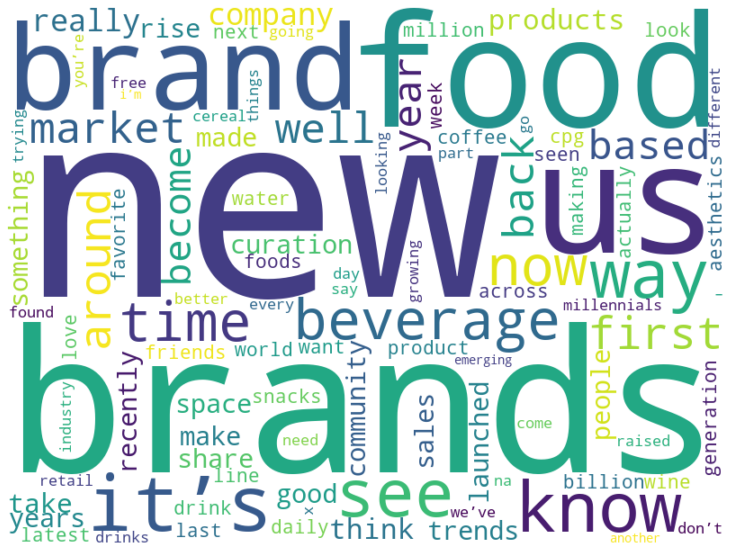

In [115]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Normalization and Preprocessing

In [116]:
#building out a normalization dict to perform prior to stemming
normalization_dict = {'was' : 'be', 'is' : 'be', 'are': 'be', 'been': 'be', 'were': 'be', 'am' : 'be', 
                      'wasnt':'isnt', 'arent':'isnt', 'werent':'isnt', 'does': 'do', 'has': 'have', 'had' : 'have',
                      'so':'', 'such':'', 'the':'', 'a':'', 'an':'', 'to': '', 'of':'', 'in':'', 'on':'', 'all':'', 
                      'for':'', 'about':'', 'at':'', 'that':'', 'this':'', 'probably':'', 'just':'', 'as':'',
                      '1':'one', '2':'two', '3':'three', '4':'four', '5':'five', '6':'six', '7':'seven', '8':'eight', '9':'nine', #numbers 
                      'he':'_pron_', 'she':'_pron_', 'i':'_pron_', 'we':'_pron_', 'you':'_pron_', 'it':'_pron_', 'they':'_pron_', #personal subject pronouns
                      'me':'_pron_', 'us':'_pron_', 'her':'_pron_', 'him':'_pron_', 'them':'_pron_', 'his':'_pron_'} #obj pron

In [117]:
#writing a preprocessing and normalization function

from nltk.stem import PorterStemmer
 
# init stemmer
porter_stemmer=PorterStemmer()
 
def basic_preprocessor(text):
       
    text=text.lower() #lower case text
    
    text = re.sub("[^a-z0-9 ]+", "", text) #remove everything except letters and numbers, and spaces (can replace with blank)
    
    #split out words for our list comprehension
    words=re.split("\\s+",text)
    
    #use the normalization words
    normalization_words = [normalization_dict[word] if word in normalization_dict.keys() else word for word in words]
    
    # stem words that aren't blank
    stemmed_words=[porter_stemmer.stem(word=word) for word in normalization_words if word != ""]
        
    return ' '.join(stemmed_words)

In [118]:
#preprocessing text
df['pre_text'] = [basic_preprocessor(text) for text in df.text]

In [119]:
#checking preprocessing
df.pre_text[0][0:100]

'newslett upcom food and beverag trend offer curat brand and aesthet written by andrea hernndezsnaxsh'

In [120]:
#pickling the preprocessed text
with open("preprocessed_text.txt", "wb") as fp:   #Pickling
    pickle.dump(list(df.pre_text), fp)

In [121]:
#tfidf_vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=True, max_df = .9, min_df = 2, ngram_range = (1,4),
                                  lowercase = False)

In [122]:
tfidf_vectors_train = tfidf_vectorizer.fit_transform(df.pre_text)

In [123]:
len(tfidf_vectorizer.vocabulary_)

40614

In [124]:
tfidf_vectors_train.shape

(152, 40614)

In [125]:
# print idf values
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights']).iloc[:20]

,idf_weights
beverag,1.125163
what,1.125163
will,1.132598
be new,1.132598
time,1.140089
curat,1.147636
one,1.147636
trend,1.155241
not,1.162903
now,1.170626


In [126]:
feature_names = tfidf_vectorizer.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tfidf_vectors_train[0]
 
#print the scores
df1 = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df1.sort_values(by=["tfidf"],ascending=False).head(15)

,tfidf
warhol,0.080254
paper bag,0.063777
paper,0.062490
invent,0.062490
supermarket,0.054813
glass,0.053088
undergo,0.052820
preserv food,0.051455
discoveri mode,0.051455
be eye,0.051455


### Trying Out SVD (Dimentionality Reduction

In [127]:
from sklearn.datasets import load_iris # Dataset
from sklearn.decomposition import TruncatedSVD # Algorithm
import matplotlib.pyplot as plt # Visualization

In [128]:
svd = TruncatedSVD(n_components=100)

# Train the model 
x_new = svd.fit_transform(tfidf_vectors_train)

In [129]:
#trying to see what the output is
x_new

array([[ 0.35827065, -0.13285158,  0.01194815, ..., -0.00615393,
        -0.12614069, -0.04390013],
       [ 0.31802699,  0.10577784,  0.16691746, ...,  0.01083493,
         0.00462773, -0.07815734],
       [ 0.28478102, -0.03013388,  0.09909386, ..., -0.03776143,
        -0.01918507,  0.0723941 ],
       ...,
       [ 0.27121432,  0.07482652, -0.1692734 , ..., -0.05087962,
        -0.01634043,  0.04490118],
       [ 0.3600661 , -0.0099552 , -0.15311105, ...,  0.07712159,
        -0.00960137, -0.03363878],
       [ 0.25813927,  0.04543006, -0.09041154, ...,  0.00851098,
         0.03402635, -0.01434651]])

## Trying KMeans on New Array

In [130]:
from sklearn.cluster import KMeans

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


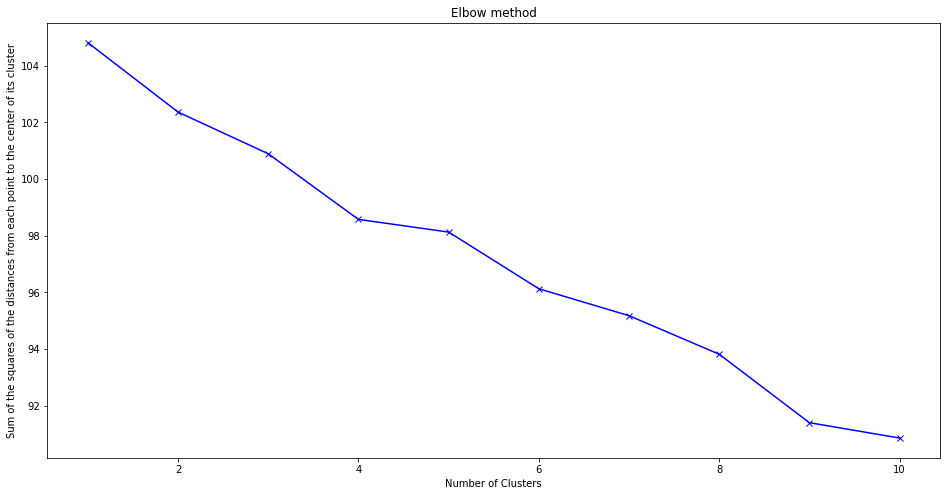

In [132]:
#list for the sum of squared distances
SQD = []

#cluster number for testing in elbow method
num_clusters = 10

# runs k-means for each cluster number
for k in range(1,num_clusters+1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x_new)
    SQD.append(kmeans.inertia_)

# sets up the plot and show it
plt.figure(figsize=(16, 8))
plt.plot(range(1, num_clusters+1), SQD, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of the squares of the distances from each point to the center of its cluster')
plt.title('Elbow method')
plt.show()

In [140]:
kmeans = KMeans(n_clusters=4).fit(x_new)

In [141]:
df['labels'] = kmeans.labels_

In [142]:
df.labels.value_counts()

2    69
1    35
0    31
3    17
Name: labels, dtype: int64

In [139]:
df.loc[df.labels == 0, 'text'].iloc[1]

"A newsletter on upcoming food and beverage trends that offers a curation of brands and aesthetics written by Andrea Hernández.\nSnaxshot is ad-free as we are community funded, if you enjoy our content, contribute here. 🤗\n“Left my heart out somewhere running\nWanting strangers to be mine”\n—Drunk in LA, Beach House\nGreetings from your favorite, non-controversial cult leader. I’m writing this letter as we set the first corner stones of our church, soon you will be able to take our sacraments of adaptogenic waters and THC crackers from wherever you may find yourself. The cult of snax is 15K worldwide, this religious experience that involves indulgence in highly curated food and beverage items. is now officially a year old. If you’ve been here long enough you can attest to the fulfillment of prophecies our dear prophet doth foretold.\nHere is a recap of our predictions come true, so the eye foresee, so was it done.\nFrom the book of Snaxers, Book One, “Rise of Sober Curious”\nWhat’s in 

## Comparing Word Clouds

In [67]:
#joining a articles together for WordCloud
text_0 = " ".join(art.lower().translate(str.maketrans('', '', string.punctuation)) for art in df.loc[df.labels == 0, 'text'])

print ("There are {} words in the combination of all articles.".format(len(text_0)))

There are 1180364 words in the combination of all articles.


In [68]:
#generating wordclouds 
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width = 800, height = 600, max_words = 100)
wordcloud.generate_from_frequencies(getFrequencyDictForText(text_0))

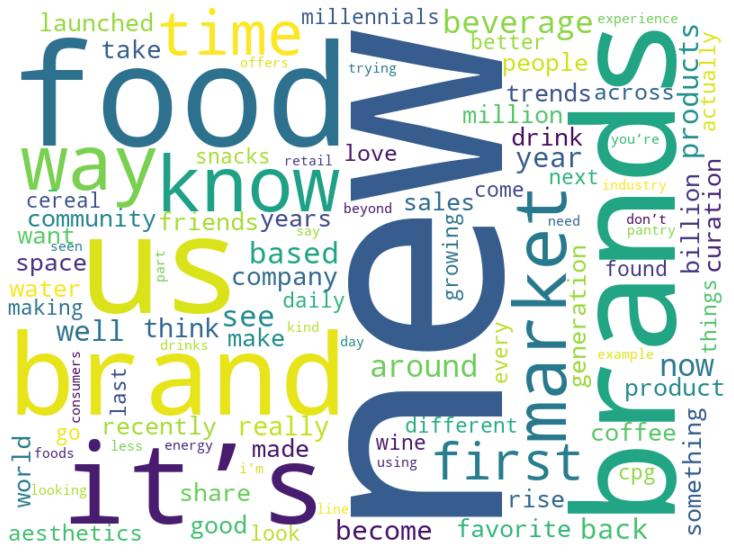

In [69]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

There are 231827 words in the combination of all articles.


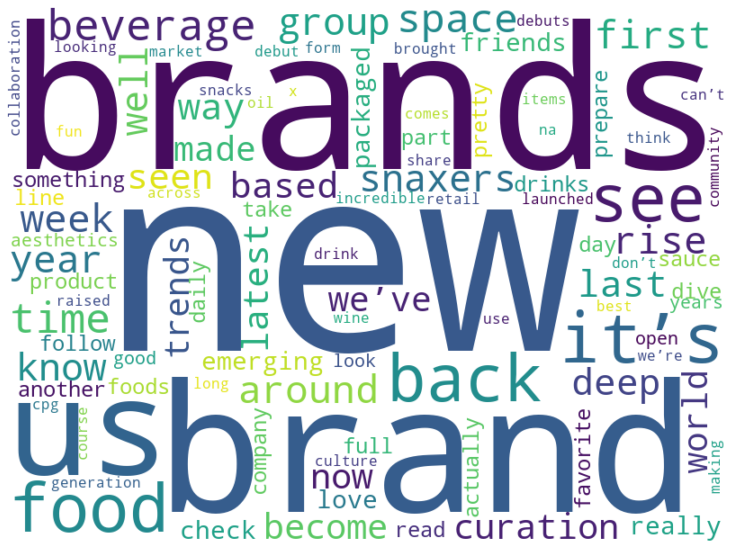

In [70]:
#joining a articles together for WordCloud
text_1 = " ".join(art.lower().translate(str.maketrans('', '', string.punctuation)) for art in df.loc[df.labels == 1, 'text'])

print ("There are {} words in the combination of all articles.".format(len(text_1)))

#generating wordclouds 
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width = 800, height = 600, max_words = 100)
wordcloud.generate_from_frequencies(getFrequencyDictForText(text_1))

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [71]:
df.head(2)

,Unnamed: 0,title,subtitle,date,images,text,text_length,title_length,pre_text,labels
0,0,Aesthet-o-Scope,"looks, they are-a-changing","JAN 27, 2022","['https://substackcdn.com/image/fetch/w_80,c_l...",A newsletter on upcoming food and beverage tre...,2341,1,newslett upcom food and beverag trend offer cu...,0
1,1,Brave New Snax World,this could be our future,"MAR 20, 2023","['https://substackcdn.com/image/fetch/w_1456,c...",Snaxshot is a newsletter on upcoming food and ...,1995,4,snaxshot be newslett upcom food and beverag tr...,1


In [143]:
df.loc[df.labels == 0, 'text_length'].mean()

1890.774193548387

In [144]:
df.loc[df.labels == 2, 'text_length'].mean()

1925.4927536231885

<AxesSubplot:xlabel='labels', ylabel='text_length'>

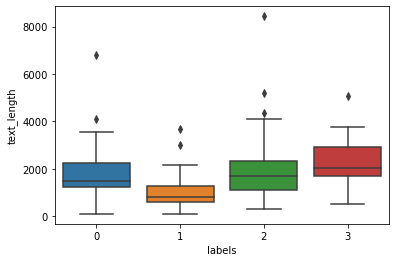

In [145]:
sns.boxplot(data=df, x="labels", y="text_length")

In [154]:
print(df.loc[0, 'text'], df.loc[0, 'labels'])

A newsletter on upcoming food and beverage trends that offers a curation of brands and aesthetics written by Andrea Hernández.
Snaxshot is ad-free as we are community funded, if you enjoy our content, contribute here. 🤗
🔮 Peek into the future:
Beauty is in the eye of the snaxboi
On origins of packaging
Andy Warhol’s CPG influence
Rebrands as the new launch
Around the world in Pantry Kiths
Oracular Spectacular and Trendspotting
Spoonful of News
Come on in, the water’s warm, you know you want to!
Subscribed
Sitting Pretty, Oh So Pretty
In defense of aestheticism, our brains literally crave beauty. Studies have shown that “beauty” literally triggers a part of our cerebellum that controls our hand movement, making us literally want to reach out for beautiful things. Beauty is in the eye of the beholder, and it involves everything from art, mates or that adaptogenic milk cardboard at your local curated grocer, it is no surprise then, to see the current state of F&B, where every item is seek

## Writing Out to CSV

In [147]:
df.drop(axis = 1, labels = ['Unnamed: 0', 'images'], inplace = True)

In [148]:
df.to_excel('processed_text.xlsx', index = False)

In [149]:
df.labels.value_counts()

2    69
1    35
0    31
3    17
Name: labels, dtype: int64